<a href="https://colab.research.google.com/github/irishryoon/COVID_19/blob/master/COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# When will COVID-19 take over US hospitals?
* This notebook shows how one can fit the SIR model to predict the dates during which US hospitals will experience bed shortage.  
* An app has been developed based on the work presented in this notebook. Check out the app: https://covid19-hospital.herokuapp.com/   
* This notebook is organized according to the following sections:  
  0. Define Functions
  1. Get data
  2. Model performance in Hubei, china  
  3. Analysis by state
  4. Analysis by county (for State of Washington)





In [0]:
# Install symfit: https://symfit.readthedocs.io/en/latest/fitting_types.html#ode-fitting
#!pip install symfit

# Install selenium
#!apt update
#!apt install chromium-chromedriver
#!pip install selenium

In [0]:
from selenium import webdriver
import regex as re
import glob
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')

import pickle 
from collections import OrderedDict
from bs4 import BeautifulSoup
from urllib.error import HTTPError
from urllib import request, response, error, parse
from urllib.request import urlopen

from symfit import Parameter, variables, Fit, D, ODEModel

# 0. Define functions 

In [0]:
abbreviation = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'}

In [0]:
def get_state_df(data, state, state_name):
  # create dataframe for selected state
  """
  --- input ---
  data: (dic) 
  state: (str) state abbreviation
  state_name: (str) state name given by abbreviation[state]

  --- output ---
  state_df: (DataFrame)
  """

  # NOTE: in "data"
  #   On some days, the "Province/State" is reported as "County, State"
  #   On some days, the Province/State" is reported as "State"

  keys = list(data.keys())
  keys.sort()
  last = keys[-1]
  columns = data[last].columns

  state_data = pd.DataFrame(columns = columns)  

  # get state data from different days
  for date in keys:
    df = data[date]
    day_data = df[(df['Country/Region'] == 'US') & 
              ((df['Province/State'] ==  state_name) | (df['Province/State'].str.contains(state))
              )]
    state_data = state_data.append(day_data, ignore_index = True)

  # sort data, from oldest (top) to newest (bottom) 
  state_data = state_data.sort_values(by = ["report date"])

  # Group by: make sure that all reported under "County, State" are aggregated to one row with "State"
  state_df = pd.DataFrame(columns = state_data.columns)

  state_df["Confirmed"] = state_data.groupby(["report date"])["Confirmed"].sum().values
  state_df["Deaths"] = state_data.groupby(["report date"])["Deaths"].sum().values
  state_df["Recovered"] = state_data.groupby(["report date"])["Recovered"].sum().values
  state_df["Province/State"] = state_name
  state_df["Country/Region"] = "US"
  state_df["report date"] = state_data.groupby(["report date"])["Confirmed"].sum().keys()
  
  # Simulate the number of recovered people on each day
  # And adjust "Confirmed" to report only the number of active cases
  # "Infected" is the number of active cases
  n_days = len(state_df["Confirmed"])
  # remove number of deaths from confirmed cases 
  infected = [state_df["Confirmed"][0] - state_df["Deaths"][0]]
  recovered_sim = [0]

  for i in range(1, n_days):
    R_day = int(sum(infected[:i]) * 0.02)
    recovered_sim.append(R_day)
    infected.append(state_df.at[i,"Confirmed"] - R_day)

  state_df["Infected"] = infected
  state_df["death_or_recovered"] = recovered_sim

  return state_df

In [0]:
def check_data_sufficiency(state_df):
  # Check if the selected state has enough data for the model. 
  # Check if the state has 5 consecutive days satisfying the following:
  #      (a) The number of confirmed cases are all above 5
  #      (b) The number of confirmed cases are increasing every day
  """
  --- input ---
  state_df: (DataFrame) output of function "get_state_df"

  --- output ---
  sufficiency = (bool) True if there is enough data
  first_day = (str if sufficiency == True, None if sufficiency == False) 
              (str) The earliest day of the possible 5 consecutive days
  last_day = (str if sufficiency == True, None if sufficiency == False) 
              (str) The last available day of data 
  """

  infected = state_df["Infected"].values
  dates = state_df["report date"].values

  first_day_found = False
  for idx, I in enumerate(infected):
    if I >= 5:
      # check if the number of infected people increases for 5 consecutive days 
      next_days = infected[idx:idx+6]

      # check if the numbers are increasing:
      if np.all(np.diff(next_days )) > 0:
        first_day_found = True
        break
      
  if first_day_found == False:
    print("Insufficient data for state ", state)

  sufficient = first_day_found
  first_day = dates[idx]
  last_day = dates[-1]

  return sufficient, first_day, last_day 

In [0]:
def fit_model(state, state_df, first_day, last_day, n_susceptible, n_days):
   # Take state data to fit the SIR model
   # Use the fitted model to make predictions for the next "n_days"

   """
   --- input ---
   state: (str) selected state. 
   state_df: (dataframe) of state data. output from function "get_state_df"
   first_day: (str) first day of data to use for model fitting. output of function "check_data_sufficiency"
   last_day: (str) last day of data to use for model fitting. output of function "check_data_sufficiency"
            NOTE: only data from "first_day" to "last_day" will be used in the parameter tuning process
   n_susceptible: (int) number of susceptible population 
   n_days: (int) number of days to make predictions. 
   --- output ---
   prediction: (dict) of prediction info
   """
    
   ### get data in correct format
   data_duration = (datetime.datetime.strptime(last_day, "%m-%d-%Y") - datetime.datetime.strptime(first_day, "%m-%d-%Y")).days + 1 
   data_time = np.array(range(0,data_duration)).astype(int) # time 0 corresponds to the first day appearing in dataframe
   first_day_idx = state_df[state_df["report date"] == first_day].index[0]
   last_day_idx = state_df[state_df["report date"] == last_day].index[0]

   data_I= np.array(state_df.loc[first_day_idx: last_day_idx, "Infected"])
   data_R = np.array(state_df.loc[first_day_idx:last_day_idx, "death_or_recovered"])
   data_S = [n_susceptible - x - data_R[idx] for idx, x in enumerate(data_I)]

   ### define variables 
   S, I, R, t = variables('S, I, R, t')

   ### find sensible initial parameter values
   dIdt = np.diff(data_I)
   dRdt = np.diff(data_R)
   gamma_0 = 0.02
   beta_0 = np.mean([(x + gamma_0 * data_I[idx] ) * n_susceptible / (data_S[idx] * data_I[idx]) for idx, x in enumerate(dIdt)])
   
   ### define parameters
   beta = Parameter('beta', beta_0)
   gamma = Parameter("gamma", gamma_0)

   ### define ODE equations 
   model_dict = {
       D(S, t): - beta * S * I / n_susceptible,
       D(I, t): beta * S* I / n_susceptible - gamma * I,
       D(R, t): gamma * I}

   ### set initial values
   I0 = data_I[0]
   S0 = n_susceptible - I0
   R0 = data_R[0]

   ### define the model
   model = ODEModel(model_dict, initial = { t : 0, S : S0, I : I0, R : R0 })

   ### fit model parameters
   fit = Fit(model, t = data_time, I = data_I, S = None, R = data_R )
   fit_result = fit.execute()

   ### make sure the parameters make sense
   # Ocassionaly (when there isn't enough data), parameters may be non-positive.
   # If this is the case, use the naive guess from data
   params = fit_result.params
   if params["beta"] <= 0 or params["gamma"] <=0 :
     params = OrderedDict()
     params["beta"] = beta_0
     params["gamma"] = gamma_0
   if params["gamma"] >= 0.1:
     params["beta"] = beta_0
     params["gamma"] = gamma_0

   ### get predictions
   tvec = np.linspace(0, n_days-1, n_days)
   outcome = model(t=tvec, **params)
   I_pred = outcome.I
   S_pred = outcome.S
   R_pred = outcome.R 

   ### save predictions
   prediction = {}
   prediction["state"] = state
   prediction["first_day"] = first_day
   prediction["last_day"] = last_day
   prediction["num_days"] = n_days
   prediction["susceptible"] = n_susceptible
   prediction["infected_pred"] = I_pred
   prediction["susceptible_pred"] = S_pred
   prediction["recovered_pred"] = R_pred
   prediction["parameters"] = params

   return prediction

In [0]:
def predict_by_age(age_statistic, age_prediction, column_prefix):
  # predict the number of hospitalization and ICU admission in each age group. 

  """
  --- input ---
  age_statistic: (array) of statistic on either
              (1) hospital admission among infected people by age group, or
              (2) ICU admission among infected people by age group
  age_prediction: (DataFrame) prediction of number of infected people by age group
                  Must have the columns ["0-19","20-44","45-54","55-64","65-74","75-84","85+"]
  column_prefix: (str) prefix to column

  --- output ---
  df      :(DataFrame) of prediction by age group and prediction total
  """
  
  age_cols = ["0-19","20-44","45-54","55-64","65-74","75-84","85+"] 
  n_rows = age_prediction.shape[0]

  # Make prediction in each age group
  m = np.repeat(age_statistic, [n_rows], axis = 0)
  pred = np.multiply(age_prediction.values, m) 
  
  columns = [column_prefix + x for x in age_cols]
  df = pd.DataFrame(pred, columns = columns)
  
  # Make total prediction
  df[column_prefix + "_total"] = df.sum(axis = 1)

  return df

In [0]:
def predict_hospitalization_ICU(region_dem, P):
  # Predict hospitalization and ICU admissiion, save to dataframe
  """
  --- input ---
  region_dem: (DataFrame) of demographic information of particular state or county.
          Must have columns ["per0-19","per20-44", "per45-54", "per55-64","per65-74", "per75-84", "per85plus"]
          that indicate the percentage of particular age group  
  P: (dict) prediction outcome of function "train_model".
            Must have the key "infected_pred" and "num_days"

  --- output ---
  P_age: (dict) prediction of number of hospital and ICU admissions 

  """

  ### Statistic for hospital admission by age group ###
  # 0. data from CDC: https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm?s_cid=mm6912e2_w#T1_down
  age_cols = ["0-19","20-44","45-54","55-64","65-74","75-84","85+"] 

  hospitalization_max = np.array([0.025, 0.208, 0.283, 0.301, 0.435, 0.587, 0.703]).reshape(1,-1)
  hospitalization_min = np.array([0.016, 0.143, 0.212, 0.205, 0.286, 0.305, 0.313]).reshape(1,-1)
  ICU_max = np.array([0.   , 0.042, 0.104, 0.112, 0.188, 0.31 , 0.29 ]).reshape(1,-1)
  ICU_min = np.array([0.   , 0.02 , 0.054, 0.047, 0.081, 0.105, 0.063]).reshape(1,-1)

  first_dt = datetime.datetime.strptime(P["first_day"], "%m-%d-%Y")

  # 1. create dataframe P_age 
  P_age = pd.DataFrame(columns = ["date", "total"] + age_cols)
  P_age["total"] = P["infected_pred"]
  n_rows = P["num_days"]
  P_age["date"] = [(first_dt + datetime.timedelta(days = x)).strftime("%m-%d-%Y") for x in range(0,n_rows)]

  # 2. Predict the number of infected people in each age group
  for idx in P_age.index:
    total = P_age.at[idx,"total"]
    P_age.loc[idx, age_cols] = (total * region_dem[["per0-19","per20-44", "per45-54", "per55-64","per65-74", "per75-84", "per85plus"]]).values[0]

  # 3. Predict number of hospital admission using "hospitalization_min"
  hos_min_df = predict_by_age(hospitalization_min, P_age[age_cols], "hos_min")
  P_age = pd.concat([P_age, hos_min_df], axis = 1)

  # 4. Predict number of hospital amidssion using "hospitalization_max"
  hos_max_df = predict_by_age(hospitalization_max, P_age[age_cols], "hos_max")
  P_age = pd.concat([P_age, hos_max_df], axis = 1)

  # 5. Predict number of ICU amidssion using "ICU_min"
  ICU_min_df = predict_by_age(ICU_min, P_age[age_cols], "ICU_min")
  P_age = pd.concat([P_age, ICU_min_df], axis = 1)

  # 6. Predict number of ICU amidssion using "ICU_max"
  ICU_max_df = predict_by_age(ICU_max, P_age[age_cols], "ICU_max")
  P_age = pd.concat([P_age, ICU_max_df], axis = 1)

  return P_age

In [0]:
def hospital_prediction(hos_prediction, n_beds, region):
# predict when the hospital will run out of beds and how many extra beds hospitals need
  """
  --- input ---
  hos_prediciton: (DataFrame) output of function "predict_hospitalization_ICU"
  n_beds: (int) number of available beds
  region: (str) region name. ex) "WA" 
  
  --- output ---
  None
  """
  last_prediction_day = hos_prediction["date"].values[-1]

  # Conservative estimate 

  over = hos_prediction[hos_prediction["hos_min_total"] > n_beds]

  min_peak_idx = (hos_prediction["hos_min_total"]).idxmax()
  min_peak = hos_prediction.at[min_peak_idx, "date"]

  if over.empty == False:
    min_day = over["date"].values[0]
    last_day = over["date"].values[-1]

    if last_day < last_prediction_day:
      print("According to a conservative estimate, hospitals in ", region, " will need more beds from ", 
          min_day, " to ", last_day)
    else:
      print("According to a conservative estimate, hospitals in ", region, " will need more beds from ", 
          min_day, " to ", last_day," and beyond.")
  
    min_beds = int(hos_prediction.at[min_peak_idx, "hos_min_total"] - n_beds)
    print("According to a conservative estimate, hospitals in ", region, " will experience the highest level of bed shortage on " 
          + min_peak + ", and they will need " + str(min_beds) + " extra beds.")

  if over.empty == True:
    min_beds = int(hos_prediction.at[min_peak_idx, "hos_min_total"])
    print("According to a conservative estimate, hospitals in ", region, " will see the highest number of COVID-19 patients on " 
          + min_peak + ", and they will need " +str(min_beds) + " beds dedicated to COVID-19 patients.")

  # Liberal estimate
  over = hos_prediction[hos_prediction["hos_max_total"] > n_beds]
  max_peak_idx = (hos_prediction["hos_max_total"]).idxmax()
  max_peak = hos_prediction.at[max_peak_idx, "date"]
  if over.empty == False:
    max_day = over["date"].values[0]
    last_day = over["date"].values[-1]
    
    if last_day < last_prediction_day:
      print("According to a liberal estimate, hospitals in ", region, " will need more beds from ", 
          max_day, " to ", last_day)
    else:
      print("According to a liberal estimate, hospitals in ", region, " will need more beds from ", 
          max_day, " to ", last_day, " and beyond.")

    max_beds = int(hos_prediction.at[max_peak_idx, "hos_max_total"] - n_beds)
    print("According to a liberal estimate, hospitals in ", region, " will experience the highest level of bed shortage on " 
          + max_peak + ", and they will need " + str(max_beds) + " extra beds.")

  if over.empty == True:
    max_beds = int(hos_prediction.at[max_peak_idx, "hos_max_total"])
    print("According to a liberal estimate, hospitals in ", region, " will see the highest number of COVID-19 patients on " 
          + max_peak + ", and they will need " +str(max_beds) + " beds dedicated to COVID-19 patients.")

In [0]:
def plot_pred(ax, P, data_df, plot_title):
  # plot the prediction 
  """
  --- input ---
  ax: plot object
  P: (dict) output from function "fit_model"
  data_df: (DataFrame) of COVID-data for selected region (country / state / county )
          Must have columns "Infected", "Deaths", "Recovered", "Recovered_sim", "report date"
          There must be one row for each "report date"  
  plot_title: (str) title of string  

  --- output ---
  plot 
  """

  # load info from prediction 
  first_day = P["first_day"]
  last_day = P["last_day"]
  first_dt = datetime.datetime.strptime(P["first_day"], "%m-%d-%Y")
  last_dt = datetime.datetime.strptime(P["last_day"], "%m-%d-%Y")
  n_days = P["num_days"] 
  tvec = np.linspace(0, n_days-1, n_days)
  data_duration = (last_dt - first_dt).days + 1
  
  # plot predictions
  ax.plot(tvec, P["infected_pred"], label='prediction: infected', c = '#F95858' ) 
  ax.plot(tvec, P["recovered_pred"], label='prediction: deceased or recovered ', c = '#6288E2') 

  # plot data
  data_df = data_df[(data_df["report date"] >= first_day) & (data_df["report date"] <= last_day)]
  ax.scatter(range(0, data_duration), 
             data_df["Infected"].values, 
             marker = 'o', 
             label = 'data: infected', 
             c = '#920808')

  ax.scatter(range(0, data_duration), 
             data_df["death_or_recovered"].values, 
             marker = 'o', 
             label = 'data: deceased or recovered', 
             c = '#244798')

  # set labels
  time_label = [(first_dt + datetime.timedelta(days = i)).date().strftime('%m-%d') for i in range(0,n_days,20)]
  ax.set_xticks(list(range(0,n_days,20))) 
  ax.set_xticklabels(time_label)
  ax.set_xlabel("date")
  ax.set_ylabel("number of people")
  ax.set_title(plot_title)

  return ax

In [0]:
def plot_hospital_pred(ax, P, pred_infected, hospital_capacity, plot_title):
  # plot predictions of hospitalization and ICU admission
  """
  --- input --- 
  ax: plot object
  P: (dict) output of function "fit_model"
  pred_infected: dataframe with columns ["total", "total_hos_min", "total_hos_max", "total_ICU_min", "total_ICU_max"]
  hospital_capacity: (int) number of hospital beds available.  
  plot_title: (str) title of plot 
  """
  first_dt = datetime.datetime.strptime(P["first_day"], "%m-%d-%Y")
  n_days = pred_infected.shape[0]

  t = list(range(0, n_days))
  ax.plot(t, pred_infected["hos_max_total"], label = 'liberal prediction: hospital beds', c = '#293EC9')
  ax.plot(t, pred_infected["hos_min_total"], label = 'conservative prediction: hospital beds', c = '#1FCED4')
  ax.plot(t, pred_infected["ICU_max_total"], label = 'liberal prediction: ICU beds', c= "#119202")
  ax.plot(t, pred_infected["ICU_min_total"], label ='conservative prediction: ICU beds', c = "#EBC400")
  ax.hlines(hospital_capacity, t[0], t[-1], label = "available hospital beds", color = '#F95858')

  # label
  time_label = [(first_dt + datetime.timedelta(days = i)).date().strftime('%m-%d') for i in range(0,n_days,20)]
  ax.set_xticks(list(range(0,n_days,20))) 
  ax.set_xticklabels(time_label )
  ax.set_xlabel("date")
  ax.set_ylabel("number of beds")
  ax.set_title(plot_title)

  return ax

# 1. Get data
  * 1) Get COVID-19 data 
  * 2) Get US population info by state and age
  * 3) Get hospital information by state

In [0]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1) Get COVID-19 data  
* Grab data from [Johns Hopkins CSSE repository](https://github.com/CSSEGISandData/COVID-19). 
* Grab data from 01/22/2020 to most recently updated data.  
* **NOTE: While the following cell runs fine today (March 26, 2020), it could raise errors in the following situations:**   
  * If future data from CSSE is reported in a different format / header.    
  * If CSSE skips its daily update. 

In [0]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
day = datetime.datetime.strptime("01-22-2020", "%m-%d-%Y").date()

data = {}
error = False 

while error == False:
    url_day = url + day.strftime("%m-%d-%Y") + '.csv'
    
    # try grabbing data from given "day"
    try:
        df = pd.read_csv(url_day)

        # get rid of unnecessary columns (Latitutde, Longitude) if such columns exist
        df.drop(columns = ["Latitude", "Longitude", "Last Update"], errors = "ignore", inplace = True)

        # create a column with report date, as given by date
        df["report date"] = [day.strftime("%m-%d-%Y")] * df.shape[0]

        # Fill NaN values
        values = {'Confirmed': 0, 'Deaths': 0, 'Recovered': 0}
        df = df.fillna(value=values)
        
        # Make header uniform
        if "Country_Region" in df.columns:
          df.rename(columns={'Country_Region':'Country/Region'}, inplace=True)
        if "Province_State" in df.columns:
          df.rename(columns={'Province_State':'Province/State'}, inplace=True)
        
        # save to Dict
        df = df[["Province/State", "Country/Region", "Confirmed", "Deaths", "Recovered", "report date"]]
        data[day.strftime("%m-%d-%Y")] = df
        
        # update to next day
        day = day + datetime.timedelta(days = 1)

    # if data from "day" doesn't exist
    except HTTPError:
        error = True 


In [0]:
# save data
#directory = '/content/drive/My Drive/'

#f = open(directory + "COVID_data_03_26.pkl","wb")
#pickle.dump(data,f)
#f.close()

## 2) Get US population info by state and age  
* Download data from https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-detail.html  
* Download the data titled "Annual Estimates of the Resident Population by Single Year of Age and Sex: April 1, 2010 to July 1, 2018 ". 
* Save the "PEP_2018_PEPSYASEX_with_ann.csv" file in Google Drive 

In [0]:
# load demograpahic data 
dem_data = '/content/drive/My Drive/PEP_2018_PEPSYASEX/PEP_2018_PEPSYASEX_with_ann.csv'
US_dem = pd.read_csv(dem_data)

# select columns that has the most recent (2018) population estimate of both sex
col = US_dem.columns[US_dem.columns.str.contains('2018', case = False ) 
                    & US_dem.columns.str.contains('sex0', case = False )]

# add state info
col = col.insert(0,"GEO.display-label")
US_dem = US_dem[col]

US_dem = US_dem.drop([0])

# rename the columns into something simpler
new_col = {x:re.sub('est72018sex0_', '',x) for x in col}
new_col["GEO.display-label"] = "GEO"

# change the names of the column 
US_dem.rename(columns = new_col, inplace = True)

# change type so that we can sum  values
US_dem.loc[:,US_dem.columns != 'GEO'] = US_dem.loc[:,US_dem.columns != 'GEO'].astype(float)


In [0]:
# Group ages according to 
# https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm?s_cid=mm6912e2_w#T1_down

# age 0-19
sum_col = ["age" + str(i) for i in range(0,20)]
US_dem["age0-19"] = US_dem[sum_col].sum( axis = 1)
  
# 20 -44
sum_col = ["age" + str(i) for i in range(20,45)]
US_dem["age20-44"] = US_dem[sum_col].sum( axis = 1)

# 45 - 54
sum_col = ["age"+str(i) for i in range(45,55)]
US_dem["age45-54"] = US_dem[sum_col].sum( axis = 1)

# 55 - 64
sum_col = ["age"+str(i) for i in range(55,65)]
US_dem["age55-64"] = US_dem[sum_col].sum( axis = 1)

# 65 - 74
sum_col = ["age"+str(i) for i in range(65,75)]
US_dem["age65-74"] = US_dem[sum_col].sum( axis = 1)

# 75 - 84
sum_col = ["age"+str(i) for i in range(75,85)]
US_dem["age75-84"] = US_dem[sum_col].sum( axis = 1)

# 85 <= already exists
US_dem = US_dem[['GEO', 'age999','age0-19','age20-44','age45-54','age55-64','age65-74','age75-84', 'age85plus']]

# rewrite in terms of percentage 

US_dem["per0-19"] = US_dem["age0-19"] / US_dem["age999"]
US_dem["per20-44"] = US_dem["age20-44"] / US_dem["age999"]
US_dem["per45-54"] = US_dem["age45-54"] / US_dem["age999"]
US_dem["per55-64"] = US_dem["age55-64"] / US_dem["age999"]
US_dem["per65-74"] = US_dem["age65-74"] / US_dem["age999"]
US_dem["per75-84"] = US_dem["age75-84"] / US_dem["age999"]
US_dem["per85plus"] = US_dem["age85plus"] / US_dem["age999"]

In [0]:
# save csv
#directory = '/content/drive/My Drive/'
#US_dem.to_csv(directory + "US_demographics.csv",index=False)

## 3) Get hospital information (number of beds) by state
* data from https://www.ahd.com/state_statistics.html


In [0]:
# create BeautifulSoup object
url = "https://www.ahd.com/state_statistics.html"
req = request.Request(
    url, 
    data=None, 
    headers={
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    }
)

html = urlopen(req)
soup = BeautifulSoup(html, "lxml") 

# table header
table_header = [x.text for x in soup.find_all('th')]

# create df
US_hospitals = pd.DataFrame(columns = table_header)

# find the table 
table = soup.find('tbody')

# find rows of table
table_rows = table.find_all('tr')

for row in table_rows:
  td = row.find_all('td')
  row = [x.text for x in td]
  row = [re.sub(',','',x) for x in row]

  row_df = pd.DataFrame(np.array([row]), columns = table_header)
  US_hospitals = US_hospitals.append(row_df)

US_hospitals.reset_index(inplace = True, drop = True)
US_hospitals["StaffedBeds"] = pd.to_numeric(US_hospitals.StaffedBeds)

US_hospitals = US_hospitals[["State", "NumberHospitals", "StaffedBeds"]]

In [0]:
# save csv
#directory = '/content/drive/My Drive/'
#US_hospitals.to_csv(directory + "US_hospitals.csv",index=False)

# 2. Model performance in Huebi, China  

* Use the data from first 22 days to build the model and make predictions   
* Population in Hubei is about 58 million 
* Model is built assuming that 0.13% of Hubei population will eventually contract the disease

In [0]:
hubei_df = pd.DataFrame(columns = df.columns)

for date in data.keys():
  df = data[date]
  hubei_data = df[((df['Country/Region'] == 'China') | (df["Country/Region"] == "Mainland China"))
                  & (df["Province/State"] == "Hubei") ]
  hubei_df = hubei_df.append(hubei_data, ignore_index = True )

# sort data, from oldest (top) to new (bottom) 
hubei_df.sort_values(by = ["report date"], inplace = True)
hubei_df.reset_index(inplace = True)

# adjust the number of infected people
hubei_df["Infected"] = hubei_df["Confirmed"] - hubei_df["Deaths"] - hubei_df["Recovered"]
hubei_df["death_or_recovered"] = hubei_df["Deaths"] + hubei_df["Recovered"]

In [0]:
percentage = 0.0013

# Population of Hubei, China
Hubei_population = 58000000
print("population: ", Hubei_population)

# Susceptible population of state
n_susceptible = percentage * Hubei_population 
print("number of susceptible population: ", int(n_susceptible ))

print("As of March 23, 2020, the cumulative number of people confirmed in Hubei, China are 67,800")
# For comparison, as of March 23 2020, the cumulative number of people confirmed
# in Hubei, China are 67,800. 
# Let's use https://www.statista.com/statistics/1090007/china-confirmed-and-suspected-wuhan-coronavirus-cases-region/

population:  58000000
number of susceptible population:  75400
As of March 23, 2020, the cumulative number of people confirmed in Hubei, China are 67,800


In [0]:
# use the first X days of data to train the model 
data_n_days = 22

first_day = hubei_df["report date"].values[0]
last_day = hubei_df["report date"].values[data_n_days]

In [0]:
P = fit_model("Hubei", hubei_df, first_day, last_day, n_susceptible, 100)

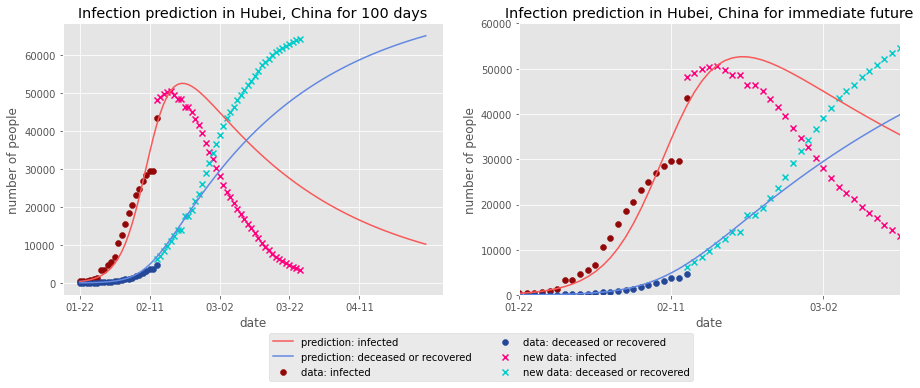

In [0]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
plot_pred(ax[0], P, hubei_df, "Infection prediction in Hubei, China for 100 days")

# zoom in on first 30 days
plot_pred(ax[1], P, hubei_df, "Infection prediction in Hubei, China for immediate future")
ax[1].set_xlim(0, 50)
ax[1].set_ylim(0,60000)

# plot the data that were not used in the model fitting process
unused_data = hubei_df[hubei_df["report date"] > last_day]
n_unused = unused_data.shape[0]
ax[0].scatter(list(range(data_n_days, data_n_days + n_unused )),unused_data["Infected"].values, 
              marker = 'x', c = '#FF007F', label = 'data: infected')
ax[0].scatter(list(range(data_n_days, data_n_days + n_unused )), unused_data["death_or_recovered"].values, 
           marker = 'x', c = '#00CCCC', label = "data: deceased or recovered")

ax[1].scatter(list(range(data_n_days, data_n_days + n_unused )),unused_data["Infected"].values, 
           marker = 'x', c = '#FF007F', label = 'new data: infected')
ax[1].scatter(list(range(data_n_days, data_n_days + n_unused )), unused_data["death_or_recovered"].values, 
           marker = 'x', c = '#00CCCC', label = "new data: deceased or recovered")

ax.flatten()[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.12), ncol=2)

# 3. Analysis by state

(1) Select state and collect state-level data  
(2) Check if the state has enough data  
  * If the state has insufficient report on confirmed cases
  * If the state has enough data on confimred cases, but does not have enough report on recovered data, simulate some recovered data before fitting model.  

(3) Select percentage of population that are susceptible to COVID-19 (USER INPUT REQUIRED)    
(4) Predict number of infections, deaths, and recoveries.  
(5) Predict hospital and ICU admission of state.   
(6) Select percentage of hospital beds available (USER INPUT REQUIRED)   
(7) Predict dates of hospital bed shortage and number of extra beds needed.   




(1) Select state, get state-level data

In [0]:
# select state using state abbreviations
state = "NY"

# Collect state-level data 
state_name = abbreviation[state]
state_df = get_state_df(data, state, state_name)

# Print most recent status
date = state_df.tail(1)["report date"].values[0]
confirmed = state_df.tail(1)["Confirmed"].values[0]
death = state_df.tail(1)["Deaths"].values[0]

print(state + " data as of ", date, ":")
print("Confirmed cases: ", confirmed)
print("Number of death: ", death)

ERROR! Session/line number was not unique in database. History logging moved to new session 66
NY data as of  03-26-2020 :
Confirmed cases:  37877
Number of death:  385


(2) Check if state has enough data

In [0]:
sufficient, first_day, last_day =  check_data_sufficiency(state_df)

(3) ***USER INPUT REQUIRED***: Select susceptible population 
* Select percentage of state population that are expected to contract COVID-19  
* As a reference, about 0.12% of the population tested positive in Hubei, China  
* As of 03/26/2020, about 0.19% of the State of New York population have tested positive. 

In [0]:
percentage = 0.01

# Population of state
state_population = US_dem[US_dem["GEO"] == state_name]["age999"].values[0]
print("state population: ", state_population)

# Susceptible population of state
n_susceptible = percentage * state_population 
print("number of susceptible population: ", n_susceptible )


state population:  19542209.0
number of susceptible population:  195422.09


(4) Predict number of infections, deaths, and recovery

In [0]:
if sufficient == False:
  print("The selected state has insufficient data for predictions.")
if sufficient == True:
  P = fit_model(state, state_df, first_day, last_day, n_susceptible, 100)

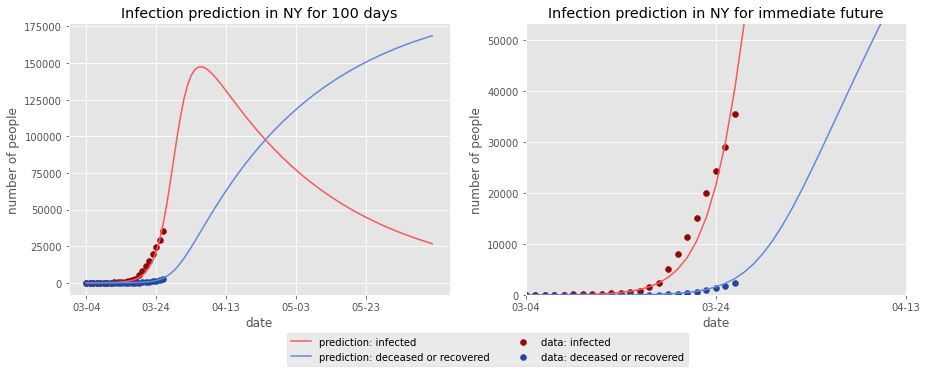

In [0]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
plot_pred(ax[0], P, state_df, "Infection prediction in " + str(state) + " for 100 days")

# zoom in on first 30 days
plot_pred(ax[1], P, state_df, "Infection prediction in " + str(state) + " for immediate future")
ax[1].set_xlim(0, 40)
ax[1].set_ylim(0,state_df.tail(1)["Infected"].values[0] * 1.5)
ax.flatten()[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.12), ncol=2)

NOTE: If the selected state doesn't have enough data on COVID-19, the model may be completely off. In such cases, the graph above will do a poor job tracing the data. If the number of "Confirmed" and "Deaths" are too low, then the model will do a poor job making its predictions. 

In [0]:
state_df.tail()

,Province/State,Country/Region,Confirmed,Deaths,Recovered,report date,Infected,death_or_recovered
20,New York,US,15800,117,0,03-22-2020,15157,643
21,New York,US,20884,158,0,03-23-2020,19938,946
22,New York,US,25681,210,0,03-24-2020,24336,1345
23,New York,US,30841,285,0,03-25-2020,29010,1831
24,New York,US,37877,385,0,03-26-2020,35465,2412


(5) Predict hospital and ICU admission 

In [0]:
# get state demographics
state_dem = US_dem[US_dem["GEO"] == state_name]

# predict hospitalization and ICU admission
hos_prediction = predict_hospitalization_ICU(state_dem, P)

(6) ***USER INPUT REQUIRED***: Select percentage of hospital beds available.  
* On average, about 35% of hospital beds are available for new patients. 

In [0]:
# select available bed percentage.
# must be between 0 and 1 
bed_percentage = 0.35

# compare to state-wide hospital capacity
state_beds = int(US_hospitals[US_hospitals["State"].str.contains(state)]["StaffedBeds"].values[0])
state_available = state_beds * bed_percentage

print("number of hospital beds in "+ state +": " , state_beds)
print("number of available beds in " + state + ": ", int(state_available))

number of hospital beds in NY:  57261
number of available beds in NY:  20041


(7) Predict hospital bed shortage

In [0]:
hospital_prediction(hos_prediction, state_available, state)

According to a conservative estimate, hospitals in  NY  will need more beds from  04-02-2020  to  04-13-2020
According to a conservative estimate, hospitals in  NY  will experience the highest level of bed shortage on 04-06-2020, and they will need 2921 extra beds.
According to a liberal estimate, hospitals in  NY  will need more beds from  03-29-2020  to  04-29-2020
According to a liberal estimate, hospitals in  NY  will experience the highest level of bed shortage on 04-06-2020, and they will need 15124 extra beds.


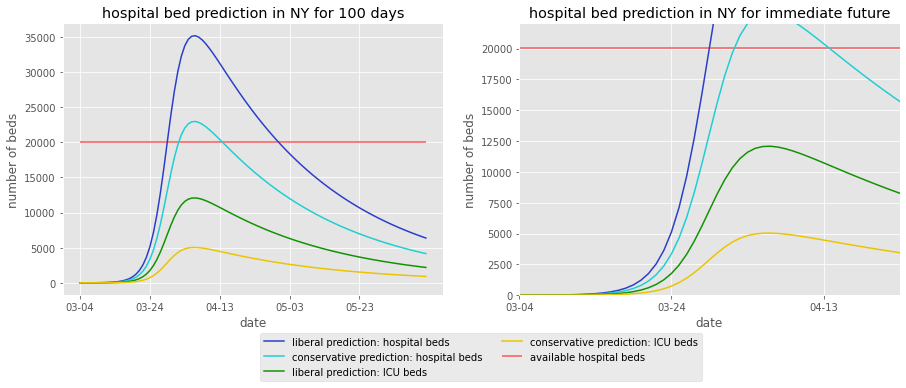

In [0]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
plot_hospital_pred(ax[0], P, hos_prediction, state_available, 'hospital bed prediction in ' + str(state) +' for 100 days')
plot_hospital_pred(ax[1], P, hos_prediction, state_available, 'hospital bed prediction in ' + str(state) + ' for immediate future')

ax[1].set_xlim(0, 50)
ax[1].set_ylim(0,state_available * 1.1)
ax.flatten()[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.12), ncol=2)

# 4. Analysis by county (in State of Washington)  
(1) Get hospital information by county in WA  
(2) Make hospital admission prediction on WA as a state  
(3) Get demographic information of WA by county  
(4) Select county and make hospital bed shortage prediction for selected county

(1) Get hospital information by county in WA  

* https://www.wsha.org/our-members/member-listing/

In [0]:
# create BeautifulSoup object
url = "https://www.wsha.org/our-members/member-listing/"
req = request.Request(
    url, 
    data=None, 
    headers={
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    }
)

html = urlopen(req)
soup = BeautifulSoup(html, "lxml") 

# find the table 
table = soup.find('table', id = 'find-hospital-list')

# find rows of table
table_rows = table.find_all('tr')

# find table header 
table_header = [x.text for x in table.find_all('th')]

# create data frame
WA_hospitals = pd.DataFrame(columns = table_header)

# add table data to data frame 
for row in table_rows:
  td = row.find_all('td')
  row = [x.text for x in td]
  if row != []:
    row_df = pd.DataFrame(np.array([row]), columns = table_header)
    WA_hospitals = WA_hospitals.append(row_df)

# replace "empty" beds with 0
WA_hospitals["Beds"] = WA_hospitals["Beds"].replace('',0)
WA_hospitals["Beds"] = WA_hospitals["Beds"].astype(int)

In [0]:
# save csv
#directory = '/content/drive/My Drive/'
#WA_hospitals.to_csv(directory + "WA_hospitals.csv",index=False)

(2) Predict the number of cases in Washington state  
* ***USER INPUT REQUIRED***: Select percentage of population that are susceptible to COVID-19. Percentage should be between 0 and 1

In [0]:
percentage = 0.01
state = "WA"

# Collect state-level data 
state_name = abbreviation[state]
state_df = get_state_df(data, state, state_name)

# Print most recent status
date = state_df.tail(1)["report date"].values[0]
confirmed = state_df.tail(1)["Confirmed"].values[0]
death = state_df.tail(1)["Deaths"].values[0]

print(state + " data as of ", date, ":")
print("Confirmed cases: ", confirmed)
print("Number of death: ", death)

# Find the first and last day used for fitting the model
sufficient, first_day, last_day =  check_data_sufficiency(state_df)

# Population of state
state_population = US_dem[US_dem["GEO"] == state_name]["age999"].values[0]
print("state population: ", state_population)

# Susceptible population of state
n_susceptible = percentage * state_population 
print("number of susceptible population: ", n_susceptible )

# Make prediction on infection
P = fit_model(state, state_df, first_day, last_day, n_susceptible, 100)

# Make hospital and ICU admission prediction
state_dem = US_dem[US_dem["GEO"] == state_name]
hos_prediction = predict_hospitalization_ICU(state_dem, P)

WA data as of  03-26-2020 :
Confirmed cases:  3207.0
Number of death:  150.0
state population:  7535591.0
number of susceptible population:  75355.91


(3) Get demographic information by county

In [0]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# grab data from website
wd = webdriver.Chrome('chromedriver',options=options)
wd.get("https://www.doh.wa.gov/emergencies/coronavirus")


In [0]:
wd.implicitly_wait(3)
# beautiful soup object
soup = BeautifulSoup(wd.page_source)

# find table
for caption in soup.find_all('caption'):
  
    if "by County" in caption.get_text():
        table = caption.find_parent('table', {'class': 'table table-striped'})

table_rows = table.find_all('tr')

# table header
WA_county_col = [x.text for x in table.find_all('th')]

# save to DataFrame
WA_county = pd.DataFrame(columns = WA_county_col)

for row in table_rows:
  county_data = [x.text for x in row.find_all('td')]
  if county_data != []:
    county_df = pd.DataFrame(np.array([county_data]), columns = WA_county_col) 
    WA_county = WA_county.append(county_df)

WA_county["Positive/Confirmed Cases"] = WA_county["Positive/Confirmed Cases"].astype(int)


In [0]:
# get percentage of cases by county 
# that is, what % of confirmed cases in WA comes from each county? 

total = WA_county[WA_county["County" ] == "Total"]["Positive/Confirmed Cases"].values[0]
WA_county["percentage"] = WA_county["Positive/Confirmed Cases"] / total

In [0]:
# save csv
#directory = '/content/drive/My Drive/'
#WA_county.to_csv(directory + "WA_county.csv",index=False)

(4) Select county and perform analysis

In [0]:
# select county
county = "King"

In [0]:
# county-level prediction for selected county 
county_percentage = WA_county[WA_county["County"] == county]["percentage"].values[0]
hos_ICU_county = hos_prediction.copy() 
hos_ICU_county.loc[:, hos_ICU_county.columns != 'date'] = hos_ICU_county.loc[:, hos_ICU_county.columns != 'date'] * county_percentage

In [0]:
# number of available beds in the selected county
county_beds = WA_hospitals[WA_hospitals["County"] == county].sum(axis = 0)["Beds"]
county_available = county_beds * 0.35

In [0]:
hospital_prediction(hos_ICU_county, county_available, county)

According to a conservative estimate, hospitals in  King  will need more beds from  04-06-2020  to  05-12-2020
According to a conservative estimate, hospitals in  King  will experience the highest level of bed shortage on 04-17-2020, and they will need 1610 extra beds.
According to a liberal estimate, hospitals in  King  will need more beds from  04-04-2020  to  05-25-2020
According to a liberal estimate, hospitals in  King  will experience the highest level of bed shortage on 04-17-2020, and they will need 3465 extra beds.


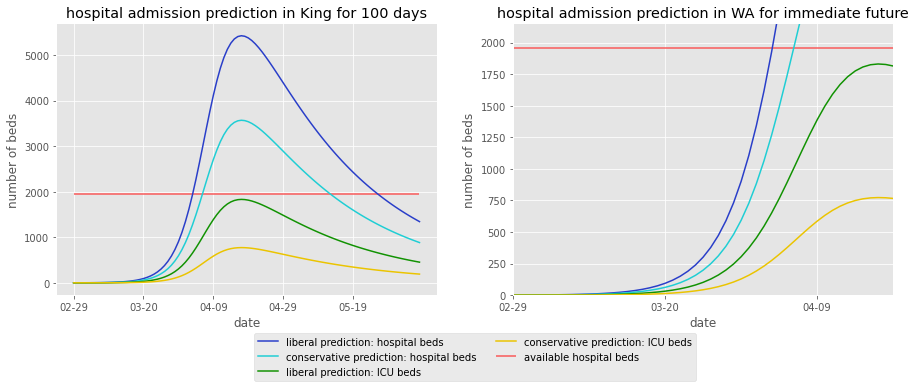

In [0]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
plot_hospital_pred(ax[0], P, hos_ICU_county, county_available, 'hospital admission prediction in ' + str(county) +' for 100 days')
plot_hospital_pred(ax[1], P, hos_ICU_county, county_available, 'hospital admission prediction in ' + str(state) + ' for immediate future')

ax[1].set_xlim(0, 50)
ax[1].set_ylim(0,county_available * 1.1)
ax.flatten()[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.12), ncol=2)

